# Exploring GLobal Energy Use with Machine Learning Models

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist
from ISLP.cluster import compute_linkage
scaler = StandardScaler()

In [2]:
np.random.seed(3799)

### Data Cleaning and Exploration

The following data comes from an Energy repository from Our World in Data, which includes indicators related to energy consuption, various energy sources, economic indicators, and electricity generation. Each row in the dataset represents a specific country in a specific year, with columns that describe how energy is used and its global impacts. 

By implementing unsupervised techniques like PCA/SVD Analysis, KMeans clustering, Matrix Completion, and Hierarchical Clustering, the objective is to find patterns, structures, or groupings among the data. Projecting high-dimensional energy data into 2D/3D space using dimensionality reduction, like PCA/SVD Analysis, might help visualize similar countries and detect outliers. Clustering techniques like KMeans might help observe countries with similar energy profiles.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv')

# Big overview variables
core_variables = ['country', 'year', 'iso_code', 'gdp', 'population',
    'primary_energy_consumption', 'energy_per_capita', 'energy_per_gdp',
    'fossil_share_energy', 'renewables_share_energy', 'nuclear_share_energy',
    'coal_share_energy', 'oil_share_energy', 'gas_share_energy',
    'hydro_share_energy', 'solar_share_energy', 'wind_share_energy',
    'electricity_generation', 'per_capita_electricity']

# Energy transition, how is energy created
transition_variables = ['country', 'year', 'gdp', 'population',
    'primary_energy_consumption', 'energy_per_capita',
    'fossil_share_energy', 'renewables_share_energy', 'nuclear_share_energy',
    'solar_share_energy', 'wind_share_energy', 'hydro_share_energy',
    'electricity_generation']

# Climate impact, how is energy being used
climate_variables = ['country', 'year', 'gdp', 'population',
    'primary_energy_consumption', 'energy_per_capita',
    'fossil_share_energy', 'renewables_share_energy']

# Small dataset, perhaps to use for testing models
minimal_variables = ['country', 'year', 'gdp', 'population',
    'energy_per_capita', 'fossil_share_energy', 'renewables_share_energy']

In [4]:
def create_analysis_dataset(df, variables, year = None, year_range=None, 
                          min_completeness = 0.8):

    analysis_df = df[variables].copy()
    initial_shape = analysis_df.shape

    # To select year or year range
    if year is not None:
        analysis_df = analysis_df[analysis_df['year'] == year]
    elif year_range is not None:
        start_year, end_year = year_range
        analysis_df = analysis_df[
            (analysis_df['year'] >= start_year) & 
            (analysis_df['year'] <= end_year)
        ]

    # Variables to exclude
    if 'country' in variables:
        regions_to_exclude = [
            'World', 'Europe', 'Asia', 'Africa', 'North America', 'South America',
            'European Union', 'OECD', 'G20', 'G7', 'High-income countries',
            'Upper-middle-income countries', 'Lower-middle-income countries',
            'Low-income countries', 'Asia Pacific', 'Middle East', 'Europe (other)',
            'CIS', 'Other Caribbean', 'Other Middle East', 'Other Africa',
            'Other Asia Pacific', 'Other Europe', 'Other South America']
        
        analysis_df = analysis_df[~analysis_df['country'].isin(regions_to_exclude)]
    
    numeric_cols = [col for col in variables if col not in ['country', 'year', 'iso_code']]
    completeness_by_row = analysis_df[numeric_cols].notna().mean(axis = 1)
    
    complete_rows = completeness_by_row >= min_completeness
    analysis_df = analysis_df[complete_rows]
    removed_incomplete = (~complete_rows).sum()
    
    analysis_df = analysis_df.dropna() 

    return analysis_df

In [5]:
ANALYSIS_YEAR = 2021

datasets = {}

datasets['core'] = create_analysis_dataset(
    df, core_variables, year = ANALYSIS_YEAR, min_completeness = 0.7)

datasets['transition'] = create_analysis_dataset(
    df, transition_variables, year = ANALYSIS_YEAR, min_completeness = 0.8)

datasets['climate'] = create_analysis_dataset(
    df, climate_variables, year = ANALYSIS_YEAR, min_completeness = 0.9)

datasets['minimal'] = create_analysis_dataset(
    df, minimal_variables, year = ANALYSIS_YEAR, min_completeness = 0.95)


In [6]:
core_df = datasets['core']
transition_df = datasets['transition']
climate_df = datasets['climate']
minimal_df = datasets['minimal']

In [7]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3799, stratify = y)

## PCA/SVD Analysis

In [8]:
info_cols = core_df[['country', 'year', 'iso_code']]
X_core = core_df[['gdp', 'population', 'primary_energy_consumption', 'energy_per_capita', 'energy_per_gdp',
    'fossil_share_energy', 'renewables_share_energy', 'nuclear_share_energy', 'coal_share_energy', 
    'oil_share_energy', 'gas_share_energy', 'hydro_share_energy', 'solar_share_energy', 'wind_share_energy',
    'electricity_generation', 'per_capita_electricity']]

X_core_scaled = scaler.fit_transform(X_core)

In [9]:
core_pca = PCA(n_components = 16)
core_scores = core_pca.fit_transform(X_core_scaled)

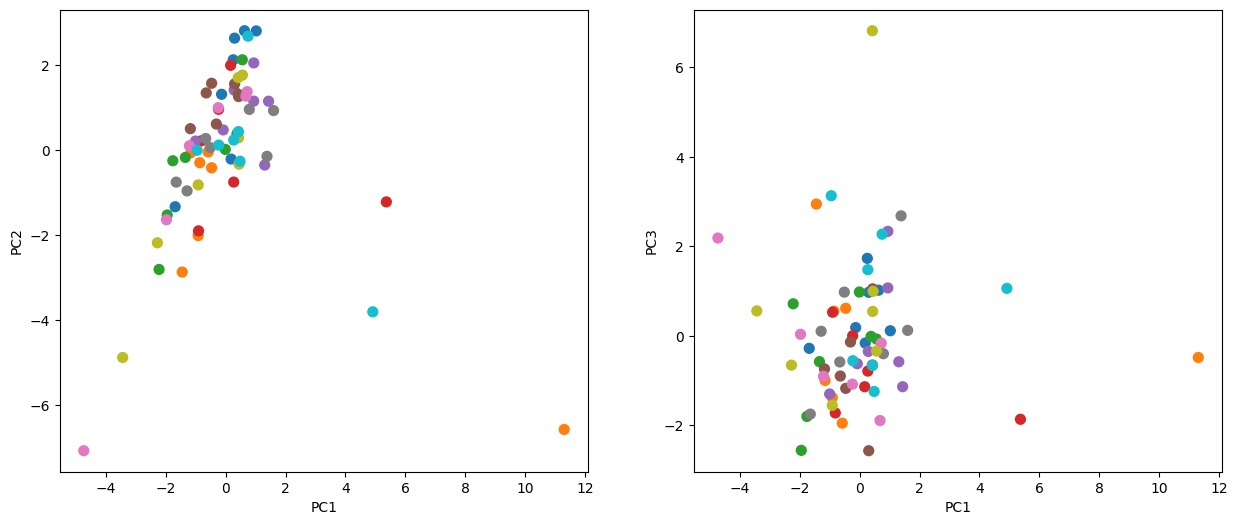

In [10]:
countries = list(np.unique(core_df['country']))
country_groups = np.array([countries.index(con)
                       for con in core_df['country'].values])

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
ax = axes[0]
ax.scatter(core_scores[:,0],
           core_scores[:,1],
           c = country_groups,
           marker ='o',
           cmap = 'tab10',
           s = 50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax = axes[1]
ax.scatter(core_scores[:,0],
           core_scores[:,2],
           c = country_groups,
           marker = 'o',
           cmap = 'tab10',
           s = 50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3');


Discussion: Plot the data in the first two principal components. What, if any, structure exists inherently within the data? How does this differ from plotting on two original features?

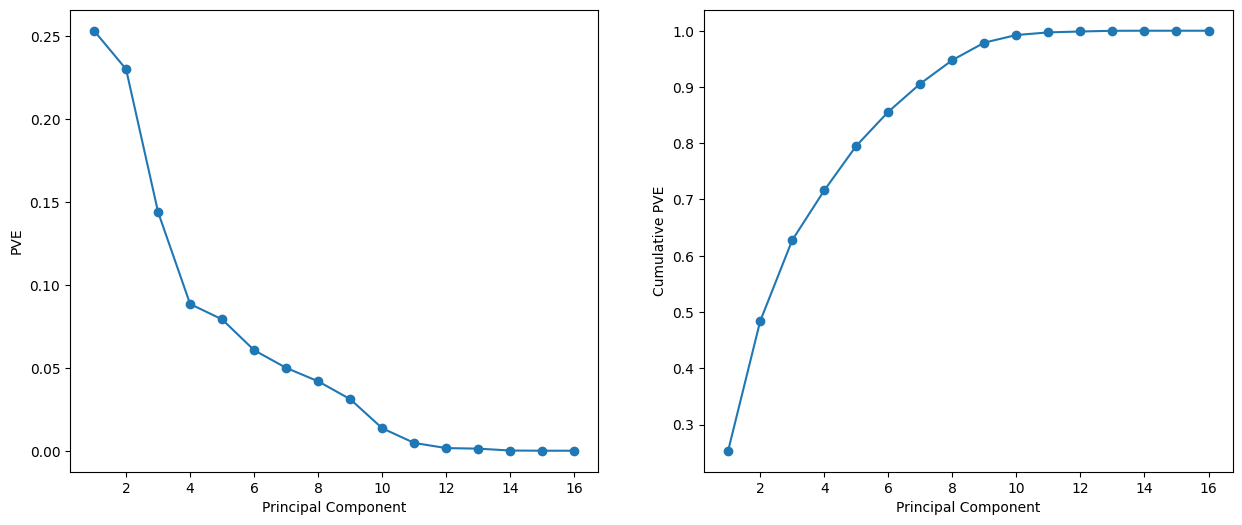

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ticks = np.arange(core_pca.n_components_)+1
ax.plot(ticks,
        core_pca.explained_variance_ratio_,
        marker = 'o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('PVE')
ax = axes[1]
ax.plot(ticks,
        core_pca.explained_variance_ratio_.cumsum(),
        marker = 'o');
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE');


In [12]:

loadings = core_pca.explained_variance_ratio_
loadings


array([2.53395822e-01, 2.30203720e-01, 1.43941193e-01, 8.85067936e-02,
       7.92278237e-02, 6.06186698e-02, 4.99851767e-02, 4.18658250e-02,
       3.10837697e-02, 1.35412186e-02, 4.67383821e-03, 1.58914979e-03,
       1.24854356e-03, 1.18456519e-04, 1.62481192e-11, 1.41533424e-11])

In [13]:
'pca_model': pca,
'X_pca': X_pca,
'explained_variance_ratio': pca.explained_variance_ratio_,
'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
'components': pca.components_,
'feature_names': feature_names,
'countries': countries


SyntaxError: illegal target for annotation (2434778646.py, line 1)

Model Tuning

Model Evaluation

Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?


## K-Means Clustering

In [15]:
kmeans = KMeans(n_clusters = 5, random_state = 3799, n_init = 50).fit(X_core_scaled)

kmeans.inertia_

561.8357068404899

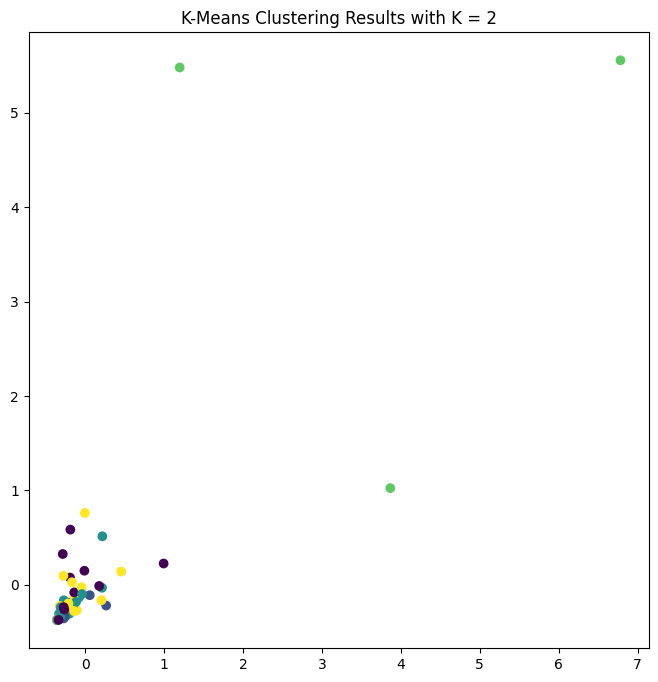

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(X_core_scaled[:,2], X_core_scaled[:,1], c = kmeans.labels_)
ax.set_title("K-Means Clustering Results with K = 2");

Discuss: In the context of your data, how can the U and V* matrix from the SVD (or "x" and "rotation" from PCA) be interpreted?

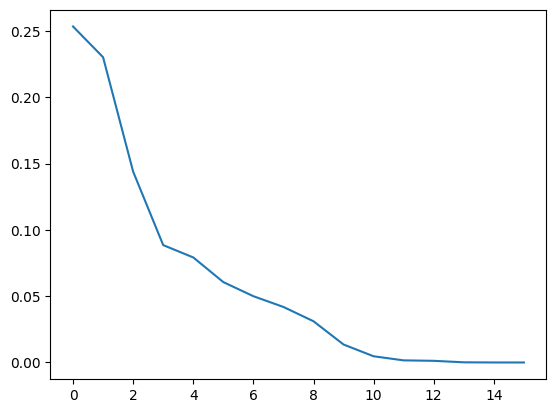

In [17]:
U, s, V = np.linalg.svd(X_core_scaled, full_matrices = False)
singular_vals = s ** 2
s_norm = singular_vals / np.sum(singular_vals)

plt.plot(s_norm)
# Most of the variance can be explained by the first ten values

In [18]:
kmeans_svd = KMeans(n_clusters = 5,
                random_state = 3799,
                n_init = 210).fit(U)

kmeans_svd.inertia_
# The within-group sum of squares is much lower now, being 16.229 down from 10469

12.468336827877213

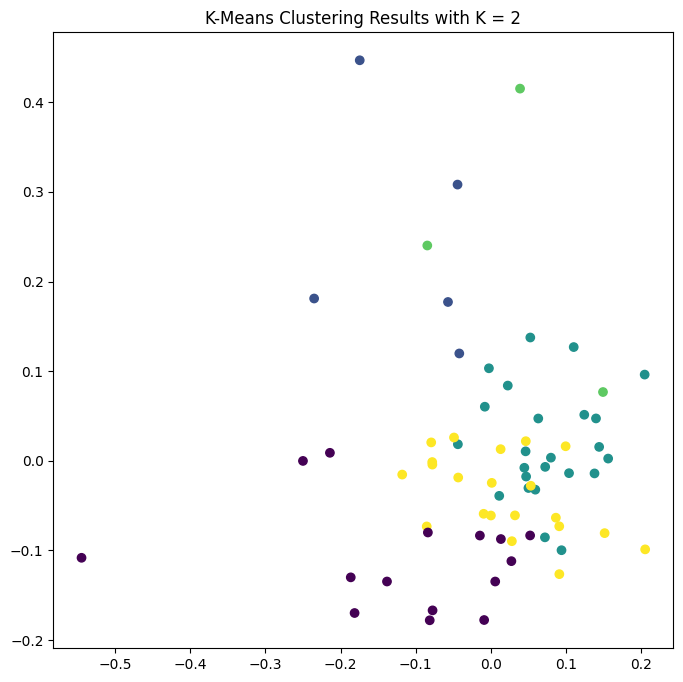

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(U[:, 2], U[:, 1], c = kmeans.labels_)
ax.set_title("K-Means Clustering Results with K = 2");

## Heirarchical Clustering

Hierarchical Clustering is an unsupervised learning method that is used to group similar data points together and organize the data into a tree-like structure called a dendrogram. The linkage of the tree is a measure of the distance between clusters before they are merged or divided. Different types of linkages will be explored to analyze the data including complete linkage, average linkage, and single linkage. The goal of implementing hierarchical clustering on this dataset is to identify clusters of countries with similar energy consumption or production patterns. This model might help uncover natural groupings that align with a country's development level, geographic region, or energy policy, potnetially even funding outlier countries that have atypical patterns of energy consumption.

In [48]:
### Data Cleaning for Hierarchical Clustering
core_df.head()

# store country names for analysis
countries = core_df['country'].values

# drop non-numeric columns
X = core_df.drop(columns=['country', 'year', 'iso_code'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Hierarchcial Clustering: Complete Linkage
Complete linkage calculates distance between clusterns by using maximum pariwise dissimilarity, or identifying the most dissimilar group. Complete linkage is useful when distance is meaningful, and it is expected for the data to have clearly seperated groups.

The following dendrogram using complete linkage shows that China and the United States form a distinct cluster in the first major split at the top of the dendrogram. This could suggest that these two countries are highly distincy from all other countries in terms of their energy profile, they are the most dissimilar group from the rest of the would. Generally, these countries are likely the top energy consumers with high GDP per capita. Their large populations sizes likely boost energy demand, even if per capital consumption varies. The energy profiles of China and the United States are more similar to eachother, even with differences in policy or country development stages, than to smaller or less industrialized countries. This cluster may represent a global outlier group that dominates the energy use, likely both quantitatively and in diversity of resources. 

In [55]:
### Hierarchical Clustering: Complete Linkage
# Define HClust
HClust = AgglomerativeClustering

# Complete linkage clustering
hc = HClust(distance_threshold=0, n_clusters=None, linkage='complete')
hc.fit(X_scaled)

# Linkage matrix
linkage_matrix = compute_linkage(hc)

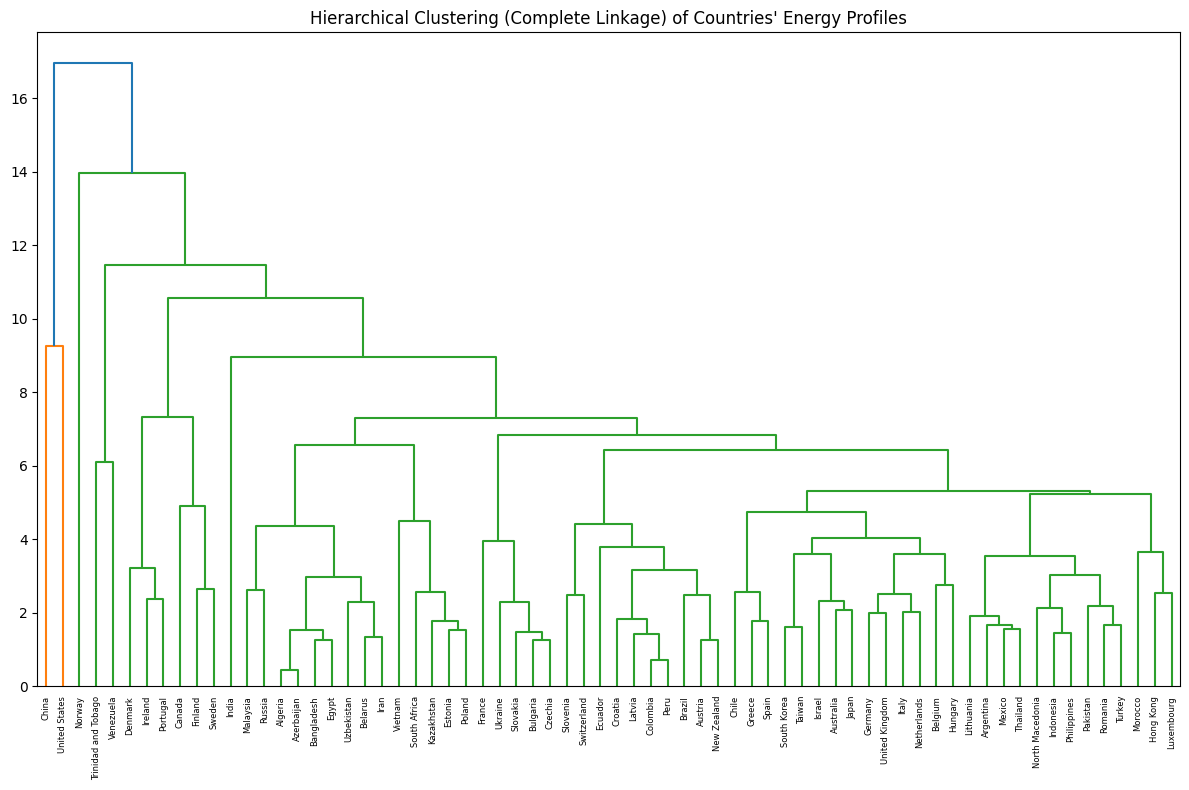

In [56]:
### Plot Dendrogram
# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 8))
dendrogram(linkage_matrix,
           ax=ax,
           color_threshold = 14,
           labels=countries,
           leaf_rotation=90)
ax.set_title("Hierarchical Clustering (Complete Linkage) of Countries' Energy Profiles")
plt.tight_layout()
plt.show()

In [57]:
### Hierarchical CLustering : Complete Linkage (2 Clusters)
# Cut the dendrogram to get 2 clusters
labels = cut_tree(linkage_matrix, n_clusters=2).flatten()

# Assign labels to the dataframe
core_df['Cluster'] = labels

# cluster membership
print(core_df[['country', 'Cluster']].sort_values('Cluster'))

             country  Cluster
757          Algeria        0
10983      Lithuania        0
11290     Luxembourg        0
11624       Malaysia        0
12006         Mexico        0
...              ...      ...
6217           Egypt        0
8246          Greece        0
21110        Vietnam        0
4503           China        1
20490  United States        1

[68 rows x 2 columns]


### Hierarchical Clustering: Single Linkage

Single linkage is calculated by finding the shortest distance between any single point among two clusters, which find the minimal intercluster dissimilarity. This method is useful in finding chain-like clusters where we might expect the data to be connected by a series of close points or irregular groupings, however this can also lead to clusters getting merged through a single data point and sensitivity to outliers. Single linkage may be misleading for such a large dataset like global energy consumption, but trends like gradual changes in energy profiles or similar geographic regions could be highlighted using this method.

The demdrogram of the single linkage verifies the initial idea that there are some countries that are clear outliers in terms of energy conumption and impact. There is a pattern where cluster 0 is a very large cluster containing the majority of the countries, which are not extremely distinct in their energy profiles. They likely share moderate use of energy levels, fossil fuel reliance, and limmited sources of nuclear or renewable energy. China is a clear outlier, which is likely seperated due to their massive total energy consumption and large population. Countries that follow are Norway and the United States, with also very different energy profiles and are outliers to the rest of the countries.

In [52]:
### Hierarchical Clustering: Single Linkage
# Define HClust
HClust = AgglomerativeClustering

# Complete linkage clustering
hc = HClust(distance_threshold=0, n_clusters=None, linkage='single')
hc.fit(X_scaled)

# Linkage matrix
linkage_matrix = compute_linkage(hc)

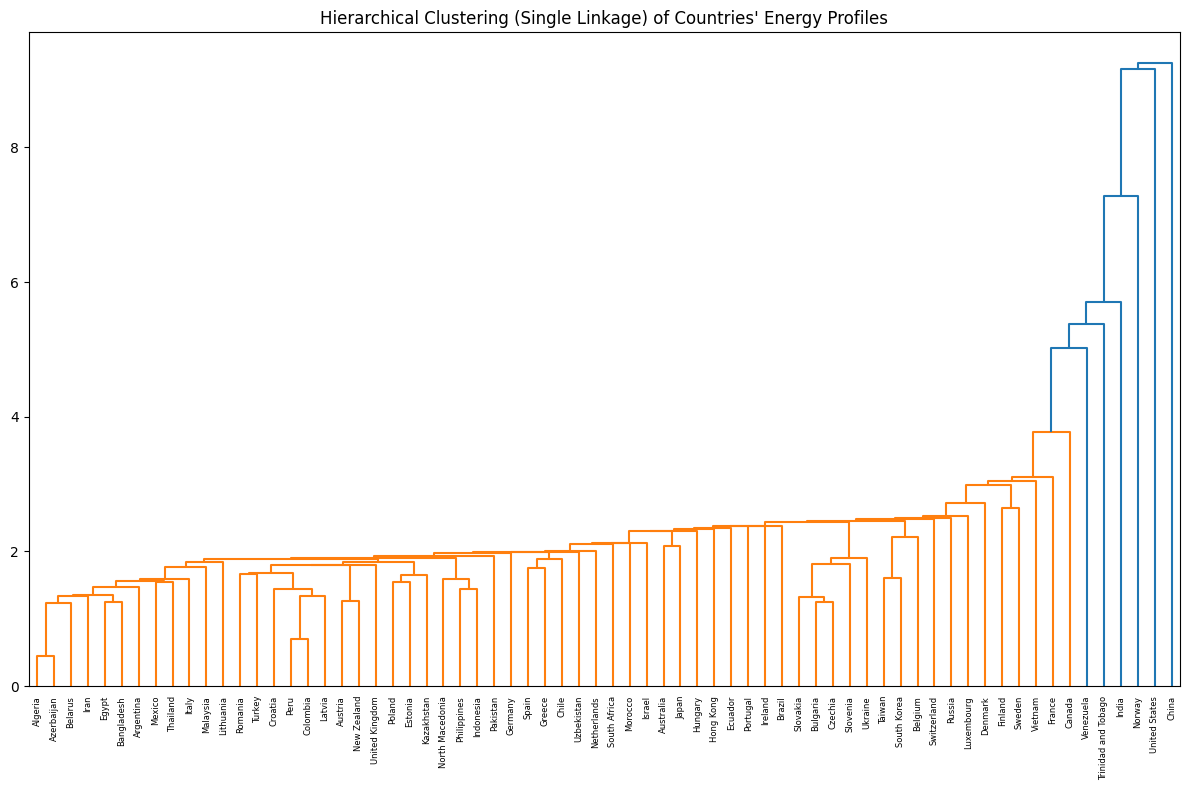

In [53]:
### Plot Dendrogram
# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 8))
dendrogram(linkage_matrix,
           ax=ax,
           color_threshold = 4,
           labels=countries,
           leaf_rotation=90)
ax.set_title("Hierarchical Clustering (Single Linkage) of Countries' Energy Profiles")
plt.tight_layout()
plt.show()

In [54]:
### Hierarchical CLustering : Single Linkage (4 Clusters)
# Cut the dendrogram to get 4 clusters
labels = cut_tree(linkage_matrix, n_clusters=4).flatten()

# Assign labels to the dataframe
core_df['Cluster'] = labels

# Preview cluster membership
print(core_df[['country', 'Cluster']].sort_values('Cluster'))

             country  Cluster
757          Algeria        0
10983      Lithuania        0
11290     Luxembourg        0
11624       Malaysia        0
12006         Mexico        0
...              ...      ...
8246          Greece        0
21110        Vietnam        0
4503           China        1
14674         Norway        2
20490  United States        3

[68 rows x 2 columns]


## Matrix Completion